In [1]:
# E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
print(chars, '\n')

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
print(stoi , '\n')

itos = {i:s for s,i in stoi.items()}
print(itos , '\n')

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0} 

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'} 



In [5]:
def buildDataset(words , block_size):
    X , Y = [] , [] 
    for word in words:
        context = [0] * block_size
        word =  word + '.' # append a end character to word, so the generator is trained to stop
        for ch in word:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return X, Y

In [6]:
import random

def trainDevAndTestSplit(words , block_size):
    random.seed(42)
    random.shuffle(words)
    n1 = int(0.8 * len(words))
    n2 = int(0.9 * len(words))
    xtr, ytr = buildDataset(words[:n1], block_size)
    xdev, ydev = buildDataset(words[n1:n2], block_size)
    xtest, ytest = buildDataset(words[n2:], block_size)
    return torch.tensor(xtr), torch.tensor(ytr), torch.tensor(xdev), torch.tensor(ydev), torch.tensor(xtest), torch.tensor(ytest)

In [7]:
block_size = 3
xtr, ytr, xdev, ydev, xtest, ytest = trainDevAndTestSplit(words, block_size)

print(xtr.shape, ytr.shape)
print(xdev.shape, ydev.shape)
print(xtest.shape, ytest.shape)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

character_embedding_size = 10
layer1_size = 200

C = torch.randn((27 , character_embedding_size) , generator = g) # character embedding
W1 = torch.randn((character_embedding_size * block_size , layer1_size) , generator = g)
b1 = torch.randn(layer1_size , generator = g)
W2 = torch.randn((layer1_size , 27) , generator = g)
b2 = torch.randn(27 , generator = g)

In [9]:
network_parameters = [C , W1 , b1 , W2, b2]
print('Total no of parameters ' , sum(p.nelement() for p in network_parameters))

Total no of parameters  11897


In [10]:
for p in network_parameters:
    p.requires_grad = True

In [11]:
def forwardAndBackwardPass(x , y , batch_size , lr):
    ix_batch = torch.randint(0 , x.shape[0], (batch_size, ))
    x_batch = x[ix_batch]
    embed_batch = C[x_batch].flatten(1)
    
    y_batch = y[ix_batch]
    
    h0 = embed_batch @ W1 + b1
    
    h1 = torch.tanh(h0)
    
    logits = h1 @ W2 + b2
    
    loss = F.cross_entropy(logits , y_batch)
    
    # backward pass 
    for p in network_parameters:
        p.grad = None
    
    loss.backward()
    
    # update grad
    for p in network_parameters:
        p.data += -lr * p.grad
        
    return loss.item()

def trainNetwork(x, y, batch_size , epochs , lr):
    loss_i = []
    iter_i = []
    
    later_training_epoch = int(0.9 * epochs)
    
    for i in range(0,epochs):
        loss = None
        
        if i > later_training_epoch:
            learning_rate_decay = lr * ( 1 / (1 + 0.01 * i)) #change the learning rate for final steps of training
            loss = forwardAndBackwardPass(x, y, batch_size , learning_rate_decay)
        else:
            loss = forwardAndBackwardPass(x, y, batch_size , lr)
            
        loss_i.append(loss)
        iter_i.append(i)
    return loss_i , iter_i

In [12]:
losses , iters = trainNetwork(xtr , ytr , 64 , 200000 , 0.1)

In [13]:
losses[-10:]

[1.8942257165908813,
 1.7774536609649658,
 2.371021032333374,
 2.033993721008301,
 1.8186655044555664,
 2.0350120067596436,
 2.162750482559204,
 2.1924843788146973,
 2.0609397888183594,
 2.270714282989502]

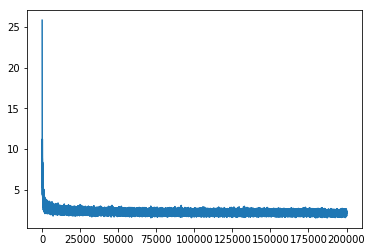

In [14]:
plt.plot(iters , losses)

In [15]:
def evaluate_loss(x,y):
    with torch.no_grad():
        emb = C[x].flatten(1)
        h0 = emb @ W1 + b1 
        h1 = torch.tanh(h0)
        logits = h1 @ W2 + b2
        loss = F.cross_entropy(logits, y)
        return loss

In [16]:
print('Training set loss ' , evaluate_loss(xtr,ytr))

Training set loss  tensor(2.1006)


In [17]:
print('Validation set loss ' , evaluate_loss(xdev,ydev))

Validation set loss  tensor(2.1540)


In [18]:
print('test set loss ' , evaluate_loss(xtest,ytest))

test set loss  tensor(2.1509)


In [19]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])].flatten(1) # (1,block_size,d)
        h0 = emb @ W1 + b1 
        h1 = torch.tanh(h0)
        logits = h1 @ W2 + b2
        
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmah.
amori.
killimri.
reytyn.
kanden.
jazhube.
delyah.
jareei.
nellara.
chaiivon.
leigh.
ham.
pris.
quinn.
shon.
malian.
quince.
madiaryxix.
kael.
ivrailey.


In [20]:
#E02: I was not careful with the intialization of the network in this video.
#(1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform?
# What loss do we achieve?

In [21]:
emb = C[xtr].flatten(1) # (1,block_size,d)
h0 = emb @ W1 + b1
h1 = torch.tanh(h0)
logits = h1 @ torch.zeros(W2.shape) + torch.zeros(b2.shape)
probs = F.softmax(logits, dim=1)

In [29]:
h1

tensor([[-1.0000,  0.9772, -0.9916,  ...,  0.9998,  0.9995,  0.9965],
        [-0.0966, -0.8553, -0.9988,  ..., -1.0000,  0.9999,  1.0000],
        [-0.9882, -0.9923, -1.0000,  ..., -0.9984,  0.9932,  0.8910],
        ...,
        [ 0.7192, -0.9998, -0.9166,  ..., -0.8532, -1.0000, -0.9999],
        [-0.6699, -0.9996, -1.0000,  ..., -0.9999, -0.9519,  0.8732],
        [-0.9978, -1.0000, -1.0000,  ..., -0.7131, -0.9994, -0.9633]],
       grad_fn=<TanhBackward0>)

In [22]:
h1[0].exp()

tensor([0.3679, 2.6570, 0.3710, 2.6354, 2.7182, 2.7183, 2.7151, 0.3748, 0.3679,
        0.3679, 2.7150, 0.3679, 0.3679, 0.3696, 2.6969, 2.5035, 0.3684, 0.3709,
        2.7095, 2.7014, 0.3703, 0.3681, 2.6198, 2.6183, 2.7142, 2.6122, 2.5759,
        2.7183, 0.3679, 2.7167, 2.5836, 0.3679, 2.7183, 2.7181, 0.3679, 0.3682,
        0.3786, 0.3679, 2.7180, 2.7183, 2.5982, 0.4012, 2.7182, 0.3679, 2.5878,
        2.5818, 0.3679, 0.3679, 2.6277, 2.7175, 0.3705, 0.3838, 2.6769, 2.7182,
        2.7171, 0.3680, 0.3680, 0.3679, 2.7182, 2.5926, 0.3703, 0.3706, 2.6438,
        2.6018, 2.6747, 2.6524, 0.3679, 0.3689, 2.7172, 0.3679, 2.7182, 2.7182,
        2.5822, 0.3722, 0.3731, 2.7148, 2.6980, 2.7182, 2.7183, 0.3679, 2.7183,
        0.3679, 0.3679, 2.7183, 0.3715, 2.6210, 0.3681, 2.5435, 2.7183, 0.4126,
        2.7183, 2.6646, 2.6423, 2.7175, 2.7183, 0.3778, 0.3679, 0.3679, 2.2381,
        0.3679, 0.3682, 0.3679, 0.3679, 2.7183, 2.6771, 2.7183, 0.3680, 0.3947,
        0.3768, 0.3679, 0.3784, 2.7152, 

In [23]:
h1[0]

tensor([-1.0000,  0.9772, -0.9916,  0.9690,  1.0000,  1.0000,  0.9988, -0.9814,
        -0.9999, -0.9999,  0.9988, -1.0000, -0.9998, -0.9954,  0.9921,  0.9177,
        -0.9985, -0.9919,  0.9968,  0.9938, -0.9935, -0.9995,  0.9631,  0.9625,
         0.9985,  0.9602,  0.9462,  1.0000, -1.0000,  0.9994,  0.9492, -1.0000,
         1.0000,  0.9999, -1.0000, -0.9991, -0.9713, -0.9999,  0.9999,  1.0000,
         0.9548, -0.9133,  1.0000, -0.9999,  0.9508,  0.9485, -1.0000, -0.9999,
         0.9661,  0.9997, -0.9929, -0.9577,  0.9847,  1.0000,  0.9996, -0.9997,
        -0.9997, -1.0000,  1.0000,  0.9527, -0.9936, -0.9927,  0.9722,  0.9562,
         0.9838,  0.9755, -0.9999, -0.9971,  0.9996, -0.9998,  1.0000,  1.0000,
         0.9486, -0.9883, -0.9858,  0.9987,  0.9925,  1.0000,  1.0000, -1.0000,
         1.0000, -1.0000, -1.0000,  1.0000, -0.9903,  0.9636, -0.9993,  0.9335,
         1.0000, -0.8853,  1.0000,  0.9800,  0.9717,  0.9997,  1.0000, -0.9733,
        -0.9998, -0.9998,  0.8056, -1.00

In [24]:
probs[1] # prodicted prob are uniform. we did this by setting w2 and b2 = 0 

tensor([0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370],
       grad_fn=<SelectBackward0>)

In [25]:
loss = F.cross_entropy(logits , ytr) # calculating the loss with the 

In [26]:
loss

tensor(3.2958, grad_fn=<NllLossBackward0>)